In [1]:
# ---------------------------
# Data Manipulation Libraries
# ---------------------------
import pandas as pd        # Handling tabular data, DataFrames, and CSV/Excel I/O
import numpy as np         # Numerical operations, arrays, linear algebra

# ---------------------------
# Data Visualization Libraries
# ---------------------------
import matplotlib.pyplot as plt   # Core plotting library
import seaborn as sns             # High-level statistical visualization

# ---------------------------
# Utilities & System Helpers
# ---------------------------
import warnings               # Manage warning messages in the notebook
from datetime import datetime # Work with dates and timestamps
import holidays               # Access country-specific holiday calendars

# ---------------------------
# Model Evaluation Metrics
# ---------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
# Used for regression evaluation and custom scoring in ML

# ---------------------------
# Predictive Modeling Libraries
# ---------------------------
import xgboost as xgb                       # Gradient boosting framework
from xgboost import XGBRegressor            # XGBoost regressor model
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate
# Splitting datasets, time-series-aware cross-validation, and model evaluation
from feature_engine.timeseries.forecasting import LagFeatures
# Create lag-based features for time series forecasting

# ---------------------------
# Classical Time Series Forecasting
# ---------------------------
from statsforecast import StatsForecast     # Unified interface for time series models
from statsforecast.models import AutoARIMA  # Automatic ARIMA modeling

# ---------------------------
# Prophet Time Series Forecasting
# ---------------------------
from prophet import Prophet                                 # Additive regression model for forecasting
from prophet.diagnostics import performance_metrics         # Evaluate model performance
from prophet.diagnostics import cross_validation            # Time-based cross-validation


warnings.filterwarnings("ignore")
color_pal=sns.color_palette()

In [2]:
df = pd.read_csv('demand_df.csv')
df['Local time'] = pd.to_datetime(df['Local time'])
df.set_index('Local time', inplace=True)
df.sort_index(inplace=True, ascending=True)
df = df.drop_duplicates()
print(df.index.duplicated().sum())

0


In [3]:
az_population = pd.read_excel('Arizona_Population.xlsx')
az_population = az_population[~az_population['Year'].isin([2000, 2001, 2002, 
                                                            2003, 2004, 2005,
                                                            2006, 2007, 2008,
                                                            2009, 2010, 2011,
                                                            2012, 2013, 2014,
                                                            2015, 2025])]

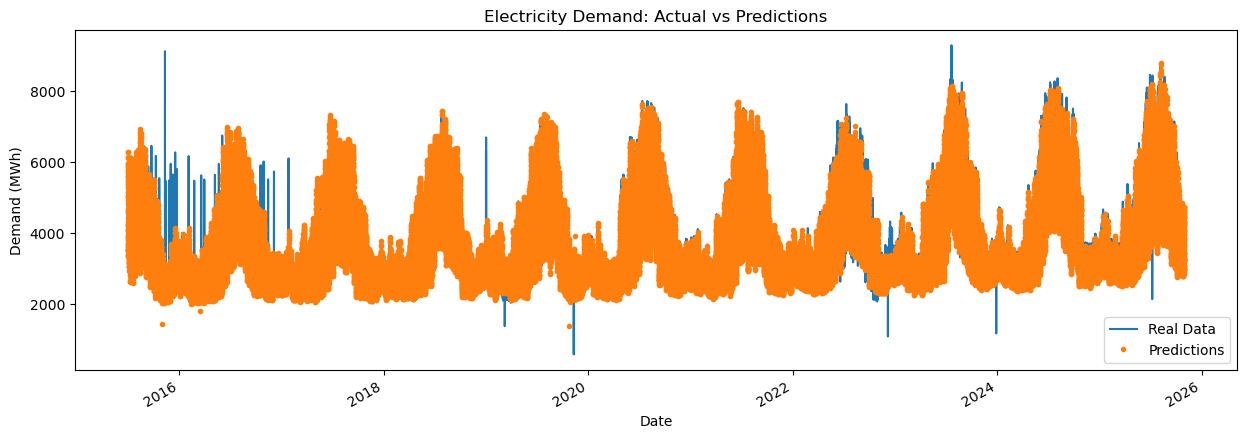

MSE: 52560.59
RMSE: 229.26
MAE: 142.78
MAPE: 3.85%
Bias: -16.48
Mean: 3682.81
RMSE % of Mean: 6.23%
R2 Score: 96.47%


In [4]:
# Extract as Series
actual = df['Demand (MWh)']
predicted = df['Demand Forecast (MWh)']

fig, ax = plt.subplots(figsize=(15,5))
df['Demand (MWh)'].plot(ax=ax)
df['Demand Forecast (MWh)'].plot(ax=ax, style='.')
plt.legend(['Real Data', 'Predictions'])
ax.set_title('Electricity Demand: Actual vs Predictions')
ax.set_ylabel('Demand (MWh)')
ax.set_xlabel('Date')
plt.show()

# Metrics
mse_value = mean_squared_error(actual, predicted)
rmse_value = np.sqrt(mse_value)
mae = mean_absolute_error(actual, predicted)
mape = (abs(actual - predicted) / actual).mean() * 100
bias = (predicted - actual).mean()
r2 = r2_score(actual, predicted) * 100
demand_mean = actual.mean()
percentage_rmse = (rmse_value / demand_mean) * 100

# Print
print(f"MSE: {mse_value:.2f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Bias: {bias:.2f}")
print(f"Mean: {demand_mean:.2f}")
print(f"RMSE % of Mean: {percentage_rmse:.2f}%")
print(f"R2 Score: {r2:.2f}%")

In [5]:
def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [6]:
df = create_features(df) 

In [7]:
# This converts all month numbers to a specific season
conditions = [
    df['month'].isin([12, 1, 2]),
    df['month'].isin([3, 4, 5]),
    df['month'].isin([6, 7, 8]),
    df['month'].isin([9, 10, 11])
]
choices = ['Winter', 'Spring', 'Summer', 'Fall']

# Apply mapping
df['Season'] = np.select(conditions, choices, default='Unknown')

In [8]:
df = df.drop_duplicates()
print(df.index.duplicated().sum())
# df.to_csv('full_df.csv')

0


In [9]:
# Commented out because I don't want duplicates being generated
#merged_df.to_csv("demand_df.csv")

In [10]:
df_season = df.groupby('Season').agg('sum').sort_values(by='Demand (MWh)', ascending=False).round()
df_season = df_season[['Demand (MWh)', 'Net Generation (MWh)',	'Demand Forecast (MWh)']]
df_season

,Demand (MWh),Net Generation (MWh),Demand Forecast (MWh)
Season,,,
Summer,117118490.0,171880139.0,116579965.0
Fall,82370088.0,136250436.0,82306804.0
Spring,69875600.0,114072990.0,69461656.0
Winter,64206581.0,114805749.0,63729641.0


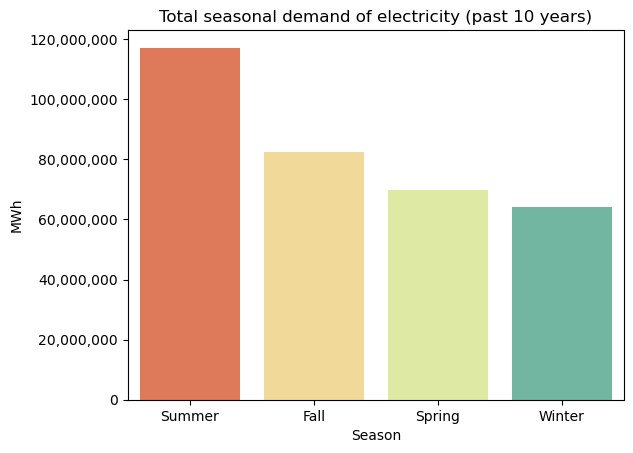

In [11]:
sns.color_palette("flare", as_cmap=True)
ax = sns.barplot(
    data=df_season,
    x=df_season.index,
    y="Demand (MWh)",
    errorbar=None,
    palette="Spectral"
)
    

# Set values to millions and add commas
ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: f'{int(x):,}')
)

ax.set_title("Total seasonal demand of electricity (past 10 years)")
ax.set_ylabel("MWh")

plt.show()

<Axes: title={'center': 'Demand for energy (MWh) from SRP customers...'}, xlabel='Local time'>

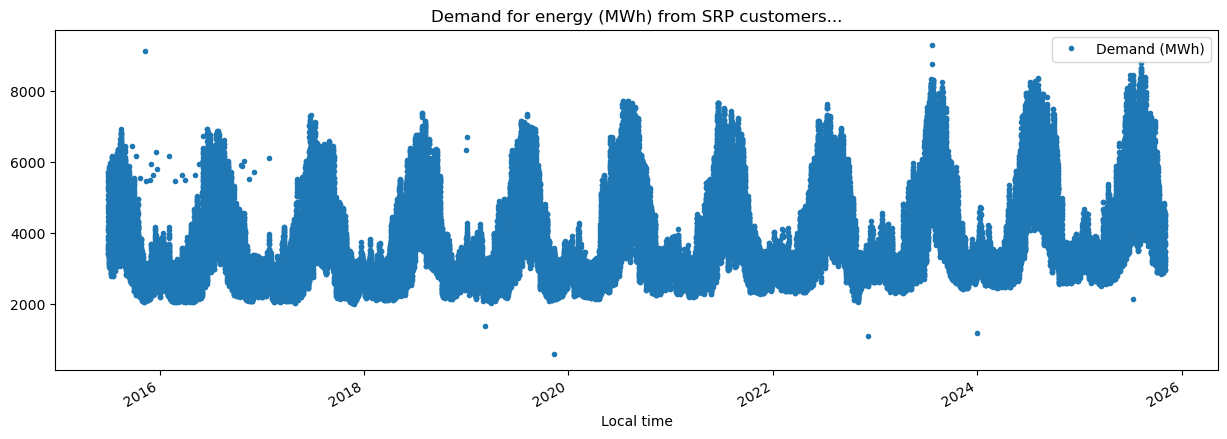

In [12]:
color_pal = sns.color_palette()
df.plot(style='.', y='Demand (MWh)', figsize=(15,5), color=color_pal[0], title='Demand for energy (MWh) from SRP customers...')

<Axes: xlabel='Local time'>

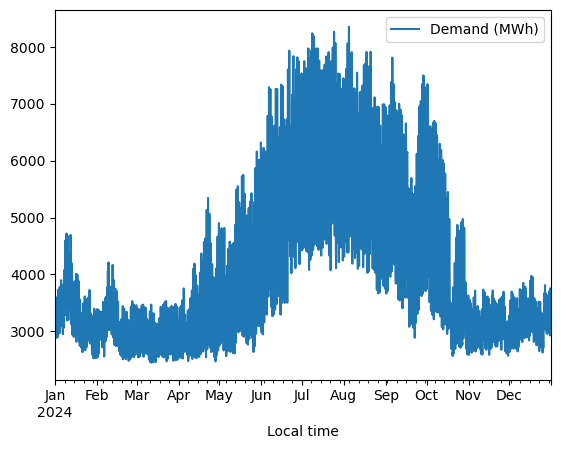

In [13]:
df.loc[(df.index >='01-01-2024 00:00:00') & (df.index <= '12-31-2024 23:00:00')].plot(y='Demand (MWh)')

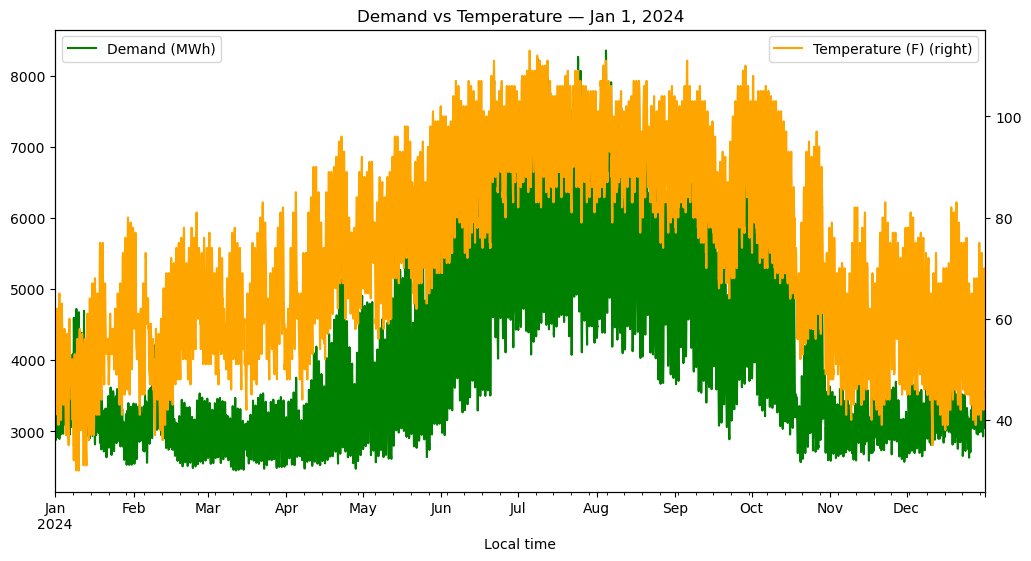

In [14]:
subset = df.loc['2024-01-01 00:00:00':'2024-12-31 23:00:00']

ax = subset['Demand (MWh)'].plot(figsize=(12,6), label='Demand (MWh)', color='green')
subset['Temperature (F)'].plot(ax=ax, secondary_y=True, label='Temperature (F)', color='orange')
ax.set_title('Demand vs Temperature — Jan 1, 2024')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')

<Axes: xlabel='Temperature (F)', ylabel='Demand (MWh)'>

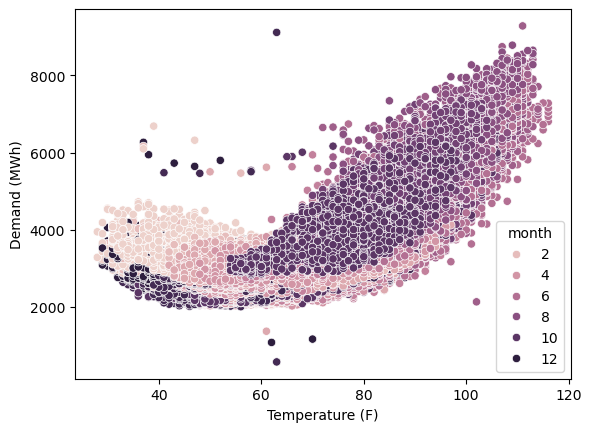

In [15]:
sns.scatterplot(data=df, x='Temperature (F)', y='Demand (MWh)', hue=df['month'])

In [16]:
us_holidays = holidays.country_holidays('US')

In [17]:
# 1. Holiday (1 = holiday, 0 = not holiday)
df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x.date() in us_holidays else 0)

# 2. Weekend flag (1 = Saturday/Sunday)
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

# 3. Daytime flag (1 = 6 AM–7 PM)
df['is_day'] = ((df.index.hour >= 6) & (df.index.hour < 20)).astype(int)

In [18]:
df[df['is_holiday'] == 1]

,Temperature (F),Demand (MWh),Net Generation (MWh),Demand Forecast (MWh),Total Interchange (MWh),hour,dayofweek,quarter,month,year,dayofyear,Season,is_holiday,is_weekend,is_day
Local time,,,,,,,,,,,,,,,
2015-07-03 00:00:00,93,4290.0,5066.0,4040.0,776.0,0,4,3,7,2015,184,Summer,1,0,0
2015-07-03 01:00:00,93,4014.0,4706.0,4083.0,692.0,1,4,3,7,2015,184,Summer,1,0,0
2015-07-03 02:00:00,91,3825.0,4387.0,3829.0,562.0,2,4,3,7,2015,184,Summer,1,0,0
2015-07-03 03:00:00,87,3688.0,4194.0,3483.0,506.0,3,4,3,7,2015,184,Summer,1,0,0
2015-07-03 04:00:00,86,3539.0,3804.0,3376.0,265.0,4,4,3,7,2015,184,Summer,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-13 19:00:00,75,4684.0,5853.0,3973.0,1168.0,19,0,4,10,2025,286,Fall,1,0,1
2025-10-13 20:00:00,76,4578.0,6032.0,3894.0,1453.0,20,0,4,10,2025,286,Fall,1,0,0
2025-10-13 21:00:00,75,4477.0,6019.0,3799.0,1542.0,21,0,4,10,2025,286,Fall,1,0,0


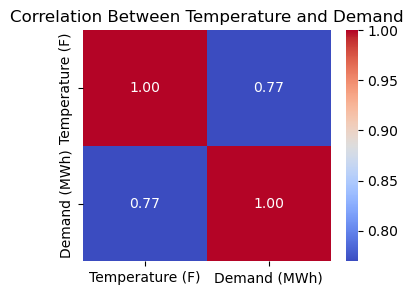

In [19]:
plt.figure(figsize=(4,3))
sns.heatmap(df[['Temperature (F)', 'Demand (MWh)']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Temperature and Demand')
plt.show()

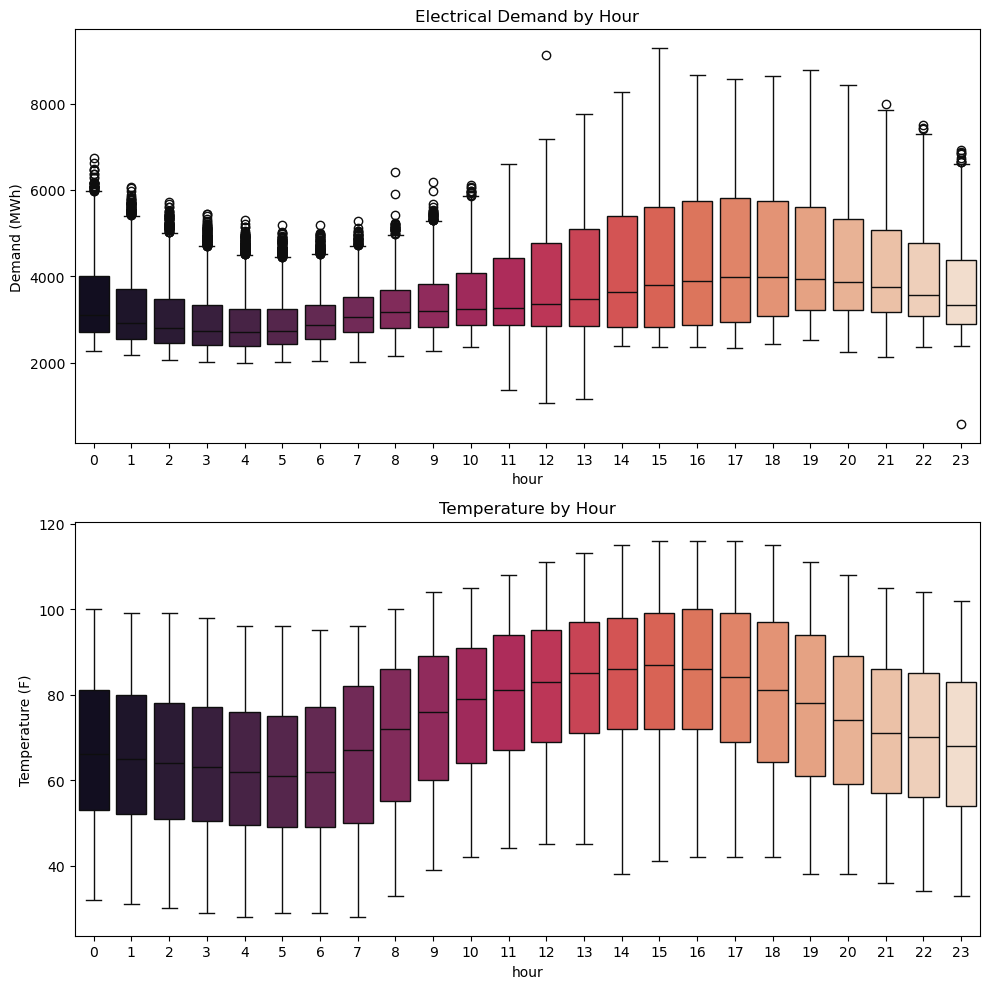

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

sns.boxplot(data=df, x='hour', y='Demand (MWh)', ax=ax[0], palette='rocket')
ax[0].set_title('Electrical Demand by Hour')
ax[0].set_ylabel('Demand (MWh)')

sns.boxplot(data=df, x='hour', y='Temperature (F)', ax=ax[1], palette='rocket')
ax[1].set_title('Temperature by Hour')
ax[1].set_ylabel('Temperature (F)')
ax[1].set_xlabel('hour')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Month')

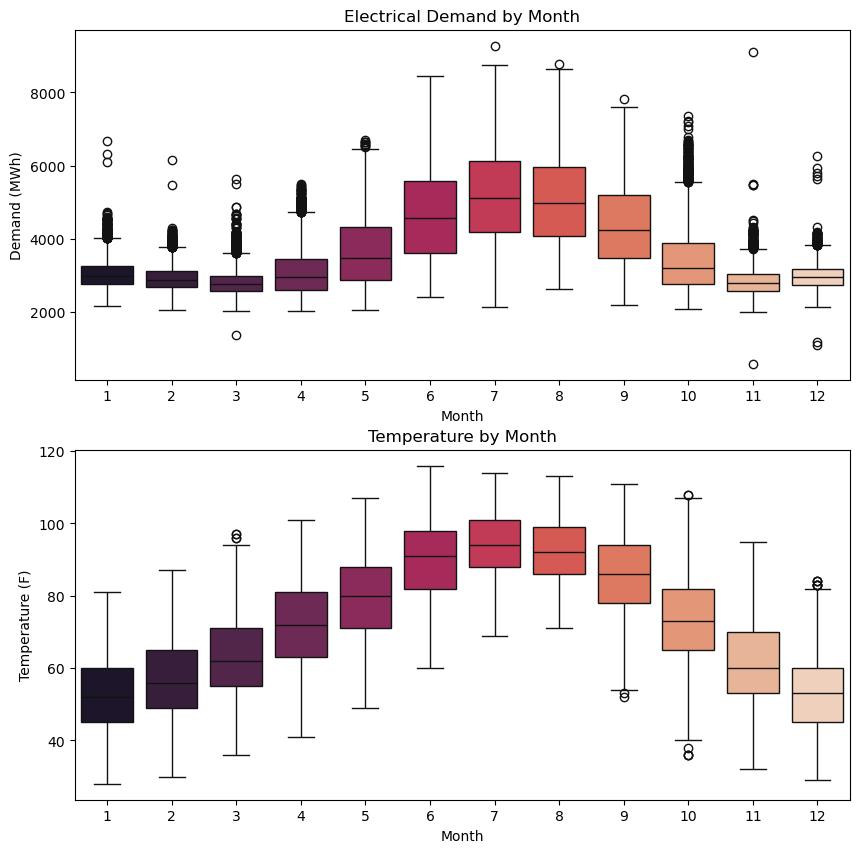

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

sns.boxplot(data=df, x='month', y='Demand (MWh)', ax=ax[0], palette='rocket')
ax[0].set_title('Electrical Demand by Month')
ax[0].set_ylabel('Demand (MWh)')
ax[0].set_xlabel('Month')

sns.boxplot(data=df, x='month', y='Temperature (F)', ax=ax[1], palette='rocket')
ax[1].set_title('Temperature by Month')
ax[1].set_ylabel('Temperature (F)')
ax[1].set_xlabel('Month')

Text(0.5, 0, '')

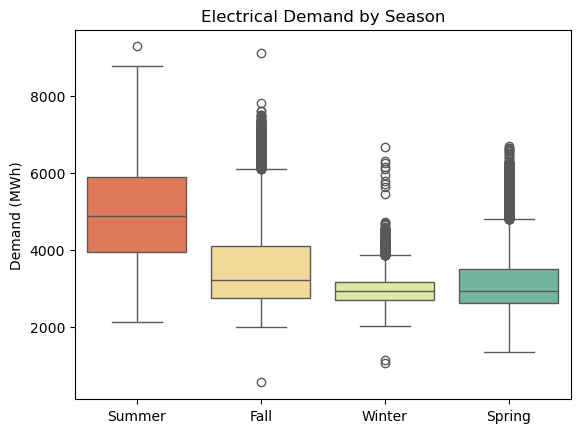

In [22]:
ax = sns.boxplot(data=df, x='Season', y='Demand (MWh)', palette="Spectral")
ax.set_title('Electrical Demand by Season')
ax.set_ylabel('Demand (MWh)')
ax.set_xlabel('')

Text(0.5, 0, '')

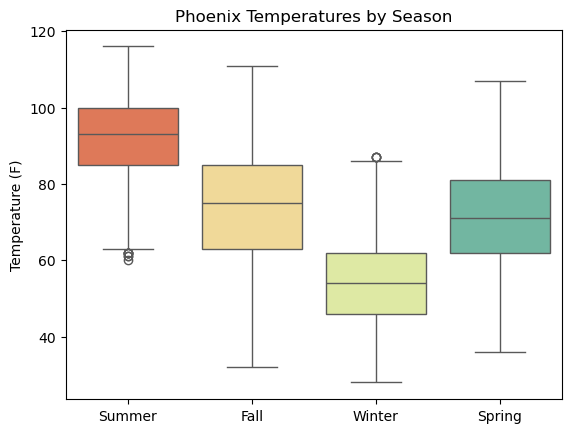

In [23]:
ax = sns.boxplot(data=df, x='Season', y='Temperature (F)', palette="Spectral")
ax.set_title('Phoenix Temperatures by Season')
ax.set_ylabel('Temperature (F)')
ax.set_xlabel('')

In [24]:
df_year = df.groupby('year').agg('sum').sort_values(by='Demand (MWh)', ascending=False).round()
df_year = df_year[['Demand (MWh)']]
df_year = df_year.sort_index(ascending=False)
df_year = df_year.reset_index()

# Filtered out 2015 and 2025 since data isn't complete
df_year = df_year[~df_year['year'].isin([2015, 2025])]

In [25]:
az_population = az_population.rename(columns={'Year': 'year'})

merged_df = pd.merge(az_population , df_year , on='year')

merged_df

# merged_df.to_csv("population_and_demand.csv")

,year,Population,Demand (MWh)
0,2024,7583692.40,35683775.0
1,2023,7475644.80,33912809.0
2,2022,7367597.20,32464874.0
3,2021,7259549.60,31793878.0
4,2020,7151502.00,32208503.0
5,2019,7268175.00,30291298.0
6,2018,7164230.00,30381482.0
7,2017,7109843.75,29804595.0
8,2016,7055457.50,29470736.0


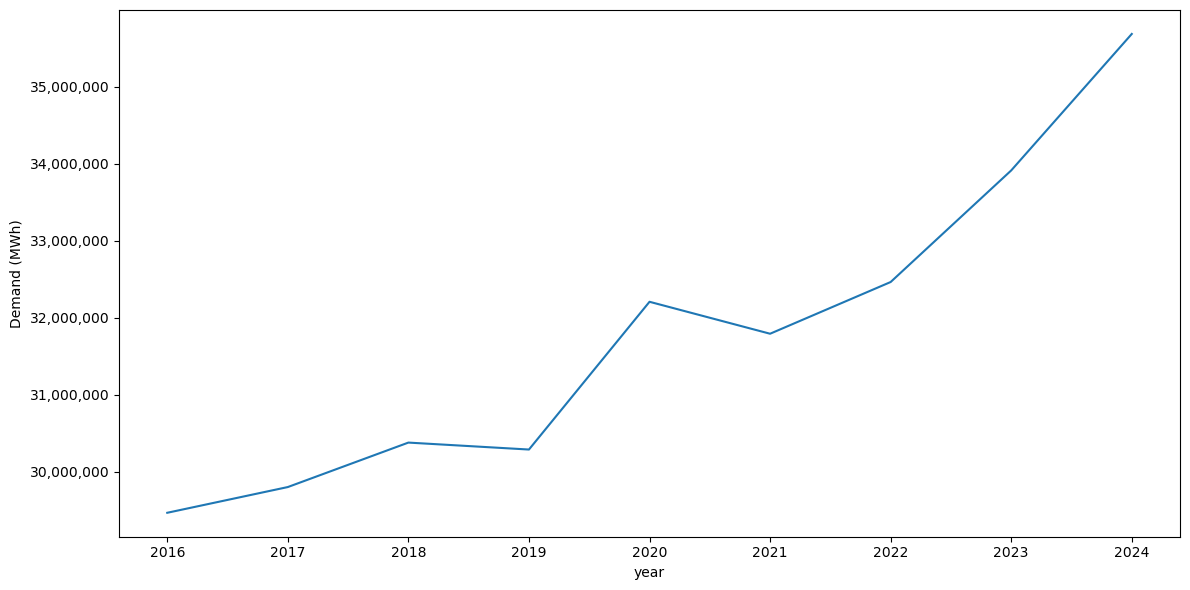

In [26]:
plt.figure(figsize=(12, 6))   # <-- ONLY place you put figsize

ax = sns.lineplot(data=df_year, x='year', y='Demand (MWh)')

# Format y-axis labels with commas
ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: f'{int(x):,}')
)

plt.tight_layout()
plt.show()

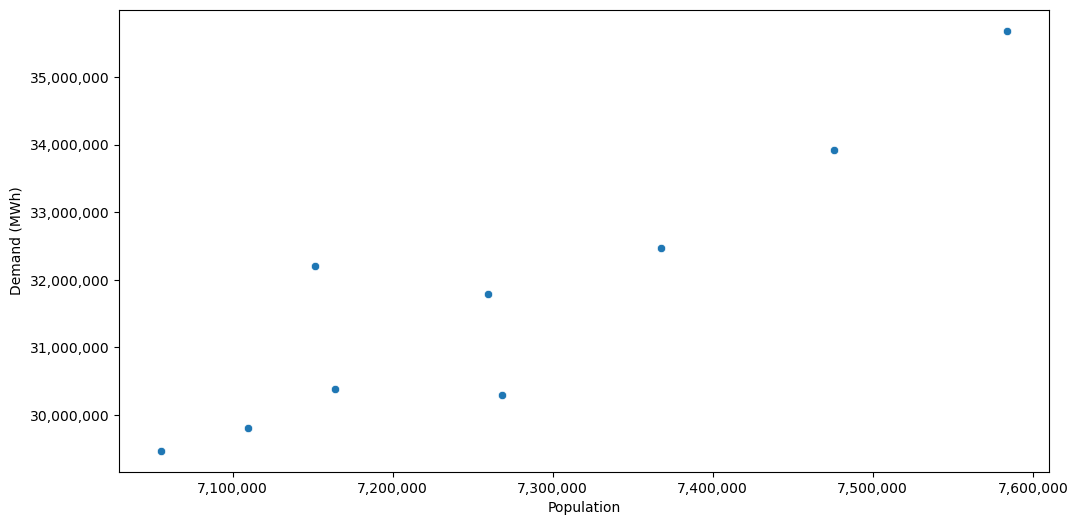

In [27]:
plt.figure(figsize=(12, 6))

ax = sns.scatterplot(data=merged_df, x='Population', y='Demand (MWh)')

ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: f'{int(x):,}')
)
ax.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: f'{int(x):,}')
)

plt.show()

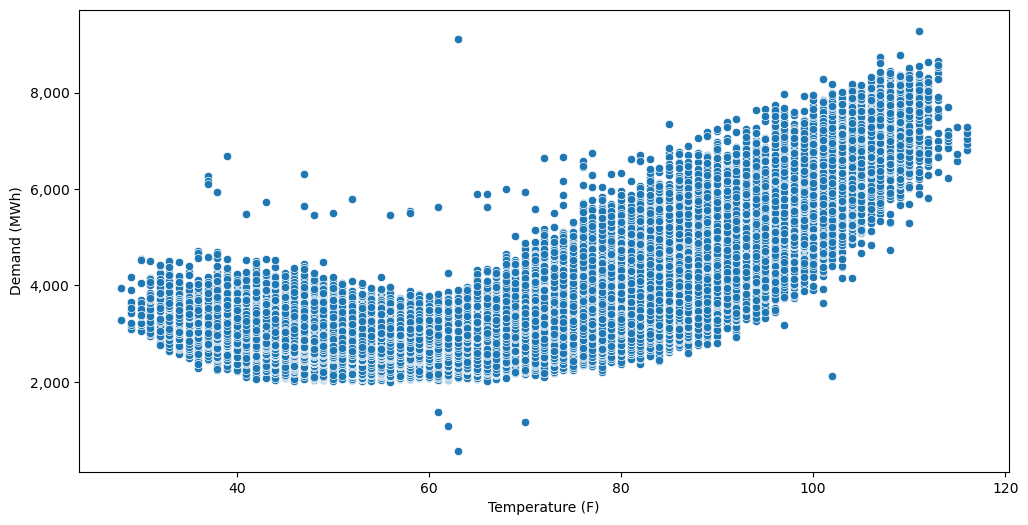

In [28]:
plt.figure(figsize=(12, 6))

ax = sns.scatterplot(data=df, x='Temperature (F)', y='Demand (MWh)')

ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: f'{int(x):,}')
)
ax.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: f'{int(x):,}')
)

plt.show()

In [29]:
df

,Temperature (F),Demand (MWh),Net Generation (MWh),Demand Forecast (MWh),Total Interchange (MWh),hour,dayofweek,quarter,month,year,dayofyear,Season,is_holiday,is_weekend,is_day
Local time,,,,,,,,,,,,,,,
2015-07-01 01:00:00,89,4103.0,4974.0,3920.0,871.0,1,2,3,7,2015,182,Summer,0,0,0
2015-07-01 02:00:00,87,3897.0,4422.0,3693.0,525.0,2,2,3,7,2015,182,Summer,0,0,0
2015-07-01 03:00:00,85,3694.0,4094.0,3610.0,400.0,3,2,3,7,2015,182,Summer,0,0,0
2015-07-01 04:00:00,83,3590.0,3865.0,3505.0,275.0,4,2,3,7,2015,182,Summer,0,0,0
2015-07-01 05:00:00,82,3546.0,3739.0,3509.0,193.0,5,2,3,7,2015,182,Summer,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,68,4213.0,5934.0,4239.0,1720.0,19,4,4,10,2025,304,Fall,0,0,1
2025-10-31 20:00:00,64,3906.0,5694.0,4054.0,1788.0,20,4,4,10,2025,304,Fall,0,0,0
2025-10-31 21:00:00,64,3747.0,5503.0,3945.0,1755.0,21,4,4,10,2025,304,Fall,0,0,0


In [30]:
df.index.duplicated().sum()
df = df[~df.index.duplicated(keep='first')]

In [31]:
lag_transformer = LagFeatures(
    variables=['Demand (MWh)'],
    periods=[1, 2, 3, 6, 24, 48, 168]
)

df_lagged = lag_transformer.fit_transform(df)
df = df_lagged.dropna()

# Creating Predictive Model

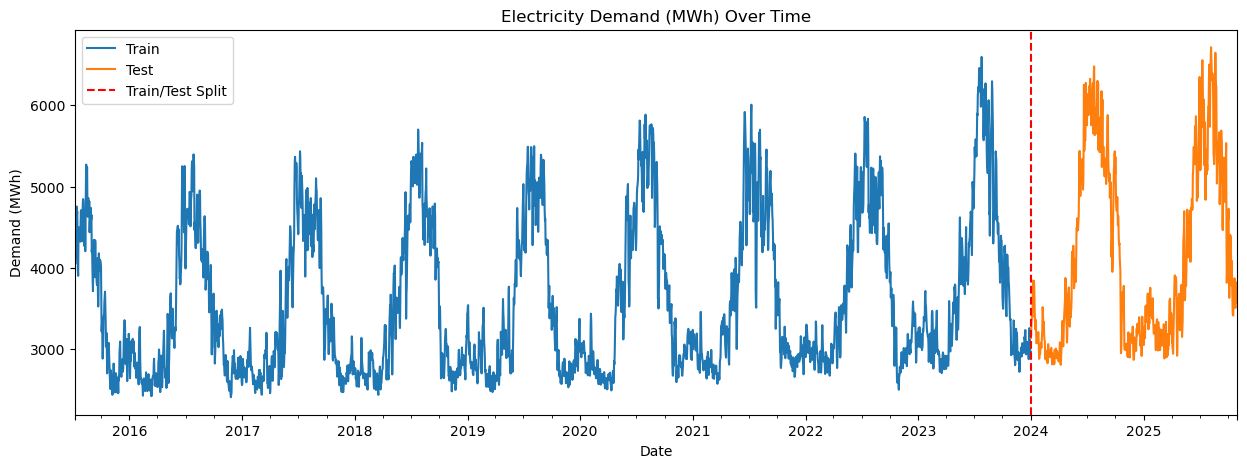

In [32]:
ml_df = df.copy()
ml_df = pd.get_dummies(ml_df, columns=['Season'], prefix='Season')

train = ml_df.loc[:'2023-12-31']
test = ml_df.loc['2024-01-01':]

fig, ax = plt.subplots(figsize=(15,5))

# Plot only Demand (MWh)
train['Demand (MWh)'].resample('D').mean().plot(ax=ax, label='Train')
test['Demand (MWh)'].resample('D').mean().plot(ax=ax, label='Test')

ax.set_title('Electricity Demand (MWh) Over Time')
ax.set_ylabel('Demand (MWh)')
ax.set_xlabel('Date')
ax.axvline(pd.Timestamp('2024-01-01'), color='red', linestyle='--', label='Train/Test Split')
ax.legend()

plt.show()

In [33]:
ml_df.columns

Index(['Temperature (F)', 'Demand (MWh)', 'Net Generation (MWh)',
       'Demand Forecast (MWh)', 'Total Interchange (MWh)', 'hour', 'dayofweek',
       'quarter', 'month', 'year', 'dayofyear', 'is_holiday', 'is_weekend',
       'is_day', 'Demand (MWh)_lag_1', 'Demand (MWh)_lag_2',
       'Demand (MWh)_lag_3', 'Demand (MWh)_lag_6', 'Demand (MWh)_lag_24',
       'Demand (MWh)_lag_48', 'Demand (MWh)_lag_168', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

In [34]:
lag_cols = [col for col in df_lagged.columns if 'Demand (MWh)_lag' in col]


"""
    'Demand (MWh)_lag_1',
    'Demand (MWh)_lag_2',
    'Demand (MWh)_lag_3',
    'Demand (MWh)_lag_6',
    'Demand (MWh)_lag_48',
    'Demand (MWh)_lag_168'
    """
FEATURES = [
    'Temperature (F)',
    'hour',
    'dayofweek',
    'month',
    'year',
    'dayofyear',
    'is_day',
    'Demand (MWh)_lag_24',
    'Season_Spring',
    'Season_Winter',
]
"""
# Removing most features made bias worse, going to use all features above ^

FEATURES = [
    'Temperature (F)',
    'hour',
    'dayofweek',
    'month',
    'year',
    'dayofyear',
    'is_day'         
]

"""
TARGET = ['Demand (MWh)']

In [35]:
lag_cols

['Demand (MWh)_lag_1',
 'Demand (MWh)_lag_2',
 'Demand (MWh)_lag_3',
 'Demand (MWh)_lag_6',
 'Demand (MWh)_lag_24',
 'Demand (MWh)_lag_48',
 'Demand (MWh)_lag_168']

In [36]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [37]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    random_state=42,
    learning_rate=0.01,
    max_depth = 3,
    min_child_weight=10,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1
)

eval_set = [(X_train, y_train), (X_test, y_test)]

reg.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=100  # prints every 10 rounds; or use True/False
)

[0]	validation_0-rmse:1149.83690	validation_1-rmse:1492.85700
[100]	validation_0-rmse:500.23115	validation_1-rmse:705.58647
[200]	validation_0-rmse:292.84664	validation_1-rmse:432.52472
[300]	validation_0-rmse:237.17874	validation_1-rmse:339.02801
[400]	validation_0-rmse:220.09513	validation_1-rmse:302.08781
[500]	validation_0-rmse:212.07077	validation_1-rmse:280.47750
[600]	validation_0-rmse:207.12079	validation_1-rmse:267.33351
[700]	validation_0-rmse:203.67604	validation_1-rmse:260.29479
[800]	validation_0-rmse:201.05293	validation_1-rmse:255.28610
[900]	validation_0-rmse:198.80160	validation_1-rmse:251.91648
[999]	validation_0-rmse:196.85445	validation_1-rmse:249.90462


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [38]:
test

,Temperature (F),Demand (MWh),Net Generation (MWh),Demand Forecast (MWh),Total Interchange (MWh),hour,dayofweek,quarter,month,year,...,Demand (MWh)_lag_2,Demand (MWh)_lag_3,Demand (MWh)_lag_6,Demand (MWh)_lag_24,Demand (MWh)_lag_48,Demand (MWh)_lag_168,Season_Fall,Season_Spring,Season_Summer,Season_Winter
Local time,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,42,2983.0,7008.0,3046.0,4025.0,0,0,1,1,2024,...,3088.0,3126.0,3172.0,2940.0,3001.0,2900.0,False,False,False,True
2024-01-01 01:00:00,41,2944.0,7012.0,2850.0,4068.0,1,0,1,1,2024,...,3015.0,3088.0,3282.0,2828.0,2906.0,2815.0,False,False,False,True
2024-01-01 02:00:00,41,2936.0,6975.0,2834.0,4039.0,2,0,1,1,2024,...,2983.0,3015.0,3187.0,2800.0,2868.0,2753.0,False,False,False,True
2024-01-01 03:00:00,41,2928.0,7026.0,2838.0,4098.0,3,0,1,1,2024,...,2944.0,2983.0,3126.0,2807.0,2835.0,2764.0,False,False,False,True
2024-01-01 04:00:00,41,2905.0,7050.0,2861.0,4145.0,4,0,1,1,2024,...,2936.0,2944.0,3088.0,2751.0,2795.0,2760.0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,68,4213.0,5934.0,4239.0,1720.0,19,4,4,10,2025,...,4523.0,4329.0,3686.0,4440.0,4527.0,4231.0,True,False,False,False
2025-10-31 20:00:00,64,3906.0,5694.0,4054.0,1788.0,20,4,4,10,2025,...,4461.0,4523.0,3983.0,4257.0,4326.0,4050.0,True,False,False,False
2025-10-31 21:00:00,64,3747.0,5503.0,3945.0,1755.0,21,4,4,10,2025,...,4213.0,4461.0,4190.0,4100.0,4205.0,3920.0,True,False,False,False


# Feature Importance

<Axes: xlabel='importance', ylabel='None'>

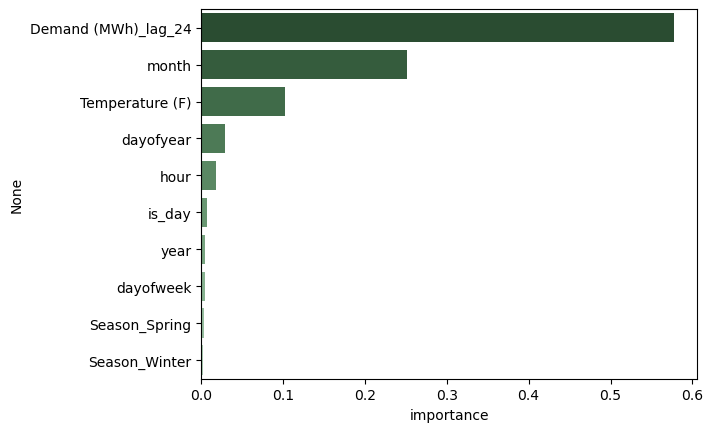

In [39]:
cmap = sns.cubehelix_palette(
    start=2, rot=0, dark=0.75, light=.25,
    reverse=False, as_cmap=True
)


feature_importance_df = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=['importance']
).sort_values(by='importance', ascending=False)

colors = [cmap(i / (len(feature_importance_df) - 1)) 
          for i in range(len(feature_importance_df))]

sns.barplot(
    data=feature_importance_df,
    x='importance',
    y=feature_importance_df.index,
    palette=colors
)

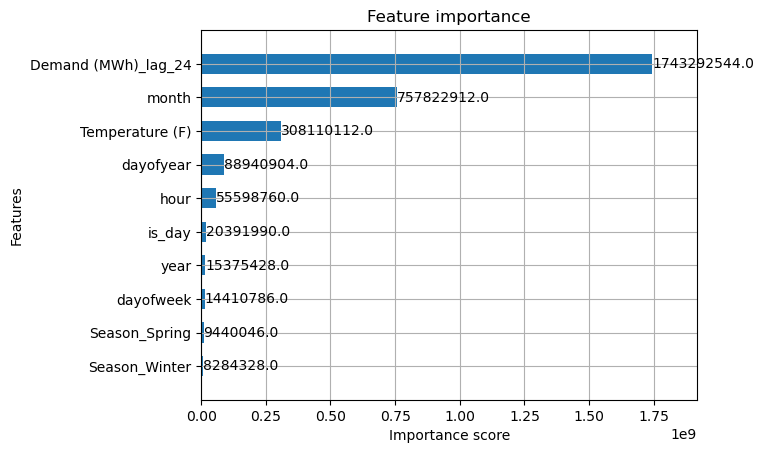

In [40]:
xgb.plot_importance(reg, max_num_features=20, importance_type='gain', height=0.6)
plt.show()

In [41]:
feature_importance_df

,importance
Demand (MWh)_lag_24,0.576931
month,0.250796
Temperature (F),0.101967
dayofyear,0.029434
hour,0.018400
is_day,0.006749
year,0.005088
dayofweek,0.004769
Season_Spring,0.003124
Season_Winter,0.002742


# Forecast on Test

In [42]:
test['ml_prediction'] = reg.predict(X_test)

ml_df = ml_df.merge(
    test[['ml_prediction']],  # ensure it's a DataFrame
    how='left',
    left_index=True,
    right_index=True
)

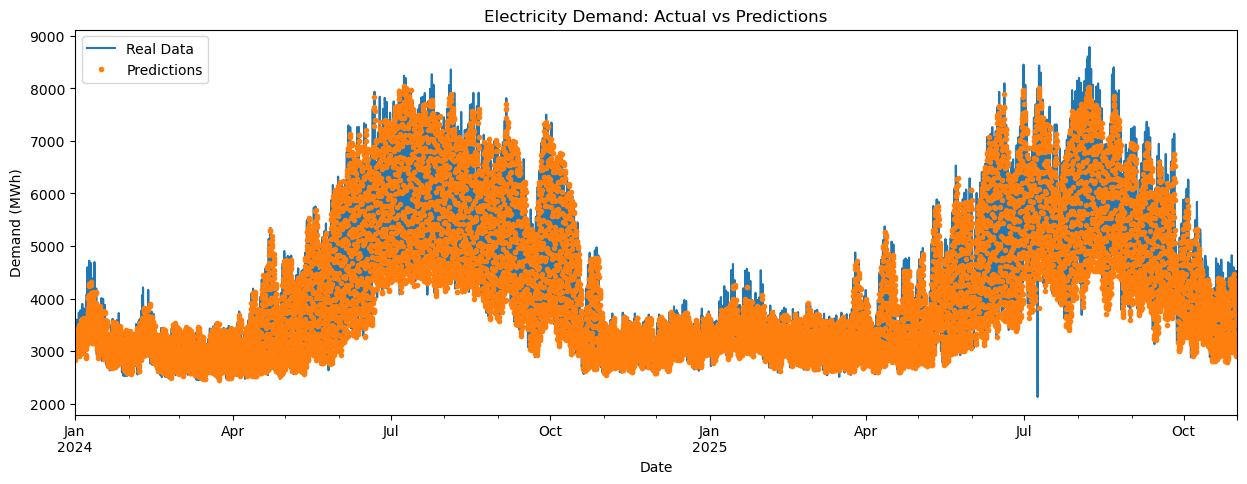

In [43]:
predicted_df = ml_df.loc['2024-01-01':]
fig, ax = plt.subplots(figsize=(15,5))
predicted_df['Demand (MWh)'].plot(ax=ax)
predicted_df['ml_prediction'].plot(ax=ax, style='.')
plt.legend(['Real Data', 'Predictions'])
ax.set_title('Electricity Demand: Actual vs Predictions')
ax.set_ylabel('Demand (MWh)')
ax.set_xlabel('Date')
plt.show()

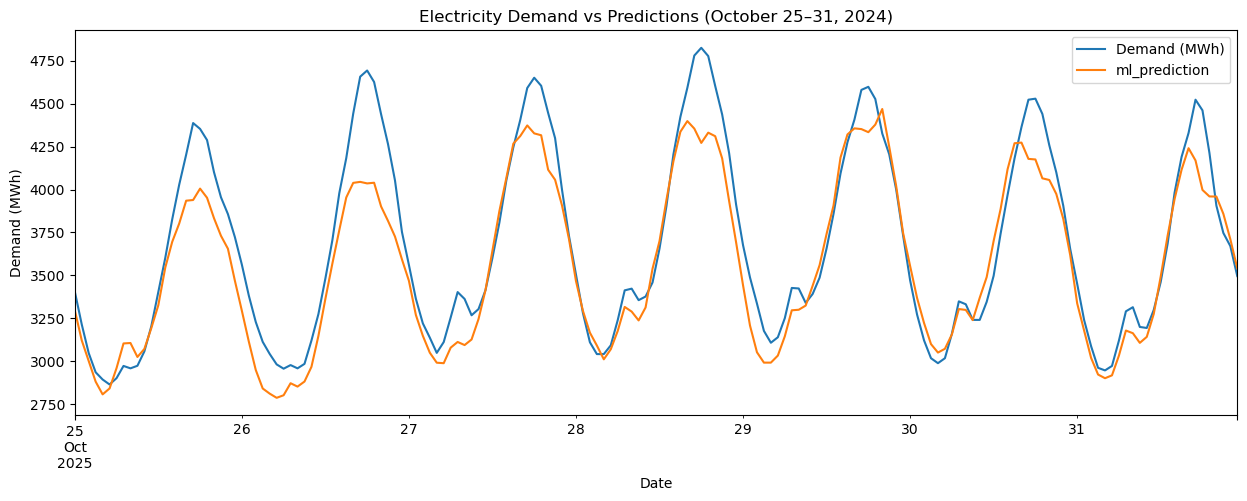

In [44]:
import matplotlib.pyplot as plt

# Select only ml_prediction and Demand for the week
week_df = ml_df.loc['2025-10-25':'2025-10-31', ['Demand (MWh)', 'ml_prediction']]

# Plot
ax = week_df.plot(figsize=(15,5))
ax.set_title('Electricity Demand vs Predictions (October 25–31, 2024)')
ax.set_ylabel('Demand (MWh)')
ax.set_xlabel('Date')
plt.show()

In [45]:
# ml_df.to_csv("xgbboost_reaL_versus_predicted.csv")

# XGBRegressor:

In [46]:
actual = test['Demand (MWh)']
predicted = test['ml_prediction']

mse_value = mean_squared_error(actual, predicted)
rmse_value = np.sqrt(mse_value)
mae = mean_absolute_error(actual, predicted)
mape = (abs(actual - predicted) / actual).mean() * 100
bias = (predicted - actual).mean()
r2 = r2_score(actual, predicted) * 100
demand_mean = actual.mean()
percentage_rmse = (rmse_value / demand_mean) * 100

print(f"MSE: {mse_value:.2f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Bias: {bias:.2f}")
print(f"Mean: {demand_mean:.2f}")
print(f"RMSE % of Mean: {percentage_rmse:.2f}%")
print(f"R2 Score: {r2:.2f}%")

MSE: 62452.32
RMSE: 249.90
MAE: 180.34
MAPE: 4.18%
Bias: -82.87
Mean: 4178.13
RMSE % of Mean: 5.98%
R2 Score: 96.69%


# Baseline:

In [47]:
# Extract as Series
actual = df['Demand (MWh)']
predicted = df['Demand Forecast (MWh)']

# Metrics
mse_value = mean_squared_error(actual, predicted)
rmse_value = np.sqrt(mse_value)
mae = mean_absolute_error(actual, predicted)
mape = (abs(actual - predicted) / actual).mean() * 100
bias = (predicted - actual).mean()
r2 = r2_score(actual, predicted) * 100
demand_mean = actual.mean()
percentage_rmse = (rmse_value / demand_mean) * 100

# Print
print("Baseline predictions:")
print(f"MSE: {mse_value:.2f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Bias: {bias:.2f}")
print(f"Mean: {demand_mean:.2f}")
print(f"RMSE % of Mean: {percentage_rmse:.2f}%")
print(f"R2 Score: {r2:.2f}%")

Baseline predictions:
MSE: 52319.61
RMSE: 228.73
MAE: 142.45
MAPE: 3.84%
Bias: -16.58
Mean: 3681.50
RMSE % of Mean: 6.21%
R2 Score: 96.49%


In [48]:
test['error'] = np.abs(test['Demand (MWh)'] - test['ml_prediction'])

In [49]:
test['date'] = test.index.date

In [50]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2024-03-13    21.445414
2024-03-15    34.000244
2024-03-09    38.113851
2024-04-14    38.348501
2024-12-03    39.797923
Name: error, dtype: float64

In [51]:
test.groupby('date')['error'].mean().sort_values(ascending=True).tail(5)

date
2025-08-20    541.562785
2025-06-03    541.718201
2025-07-21    562.335897
2025-08-21    581.316915
2024-06-21    628.991597
Name: error, dtype: float64

In [52]:
df_fc = df.reset_index().rename(columns={
    'Local time': 'ds',
    'Demand (MWh)': 'y'
})

df_fc['unique_id'] = 'demand'

df_fc = df_fc[['unique_id', 'ds', 'y']]

In [53]:
df_train = df_fc.iloc[:-24*7]
df_test  = df_fc.iloc[-24*7:]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
]

In [54]:
df_fc

,unique_id,ds,y
0,demand,2015-07-08 01:00:00,3817.0
1,demand,2015-07-08 02:00:00,3590.0
2,demand,2015-07-08 03:00:00,3396.0
3,demand,2015-07-08 04:00:00,3258.0
4,demand,2015-07-08 05:00:00,3230.0
...,...,...,...
90402,demand,2025-10-31 19:00:00,4213.0
90403,demand,2025-10-31 20:00:00,3906.0
90404,demand,2025-10-31 21:00:00,3747.0
90405,demand,2025-10-31 22:00:00,3671.0


In [55]:
sf = StatsForecast(models=models, freq='H')
sf = sf.fit(df_train)

# Forecast 642 future hours
fh = 640
pred_df = sf.predict(fh)
print(pred_df)

    unique_id                  ds        ARIMA
0      demand 2025-10-25 00:00:00  3421.726714
1      demand 2025-10-25 01:00:00  3286.555440
2      demand 2025-10-25 02:00:00  3181.005054
3      demand 2025-10-25 03:00:00  3111.791083
4      demand 2025-10-25 04:00:00  3086.335694
..        ...                 ...          ...
635    demand 2025-11-20 11:00:00  3626.181549
636    demand 2025-11-20 12:00:00  3626.181551
637    demand 2025-11-20 13:00:00  3626.181552
638    demand 2025-11-20 14:00:00  3626.181551
639    demand 2025-11-20 15:00:00  3626.181549

[640 rows x 3 columns]


In [56]:
pred_df['DateTime'] = pd.to_datetime(pred_df['ds'])

In [57]:
pred_df = pred_df.set_index('DateTime')

In [58]:
pred_df.tail(5)

,unique_id,ds,ARIMA
DateTime,,,
2025-11-20 11:00:00,demand,2025-11-20 11:00:00,3626.181549
2025-11-20 12:00:00,demand,2025-11-20 12:00:00,3626.181551
2025-11-20 13:00:00,demand,2025-11-20 13:00:00,3626.181552
2025-11-20 14:00:00,demand,2025-11-20 14:00:00,3626.181551
2025-11-20 15:00:00,demand,2025-11-20 15:00:00,3626.181549


In [59]:
df_fc = df_fc[['ds', 'y']]
df_fc

,ds,y
0,2015-07-08 01:00:00,3817.0
1,2015-07-08 02:00:00,3590.0
2,2015-07-08 03:00:00,3396.0
3,2015-07-08 04:00:00,3258.0
4,2015-07-08 05:00:00,3230.0
...,...,...
90402,2025-10-31 19:00:00,4213.0
90403,2025-10-31 20:00:00,3906.0
90404,2025-10-31 21:00:00,3747.0
90405,2025-10-31 22:00:00,3671.0


In [60]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)
m.fit(df_fc)

15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:21:34 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
90767,2026-10-27 23:00:00
90768,2026-10-28 23:00:00
90769,2026-10-29 23:00:00
90770,2026-10-30 23:00:00
90771,2026-10-31 23:00:00


In [62]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
90767,2026-10-27 23:00:00,3838.559376,2215.898442,5323.111402
90768,2026-10-28 23:00:00,3829.750876,2198.041169,5379.759459
90769,2026-10-29 23:00:00,3807.207674,2171.183164,5312.430840
90770,2026-10-30 23:00:00,3725.532005,2087.152552,5295.732666
90771,2026-10-31 23:00:00,3600.811851,1930.036285,5216.298511


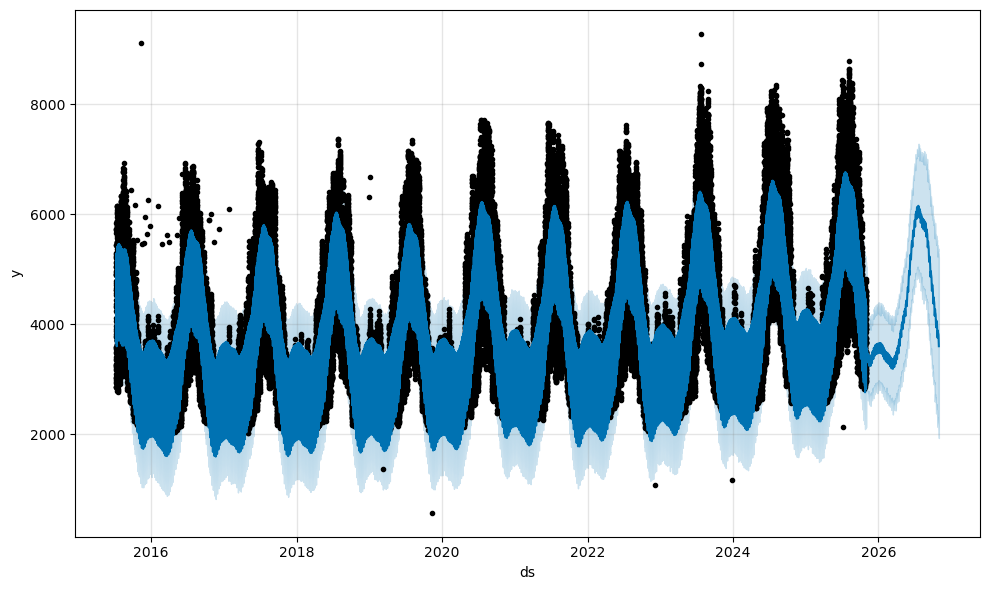

In [63]:
fig1 = m.plot(forecast)

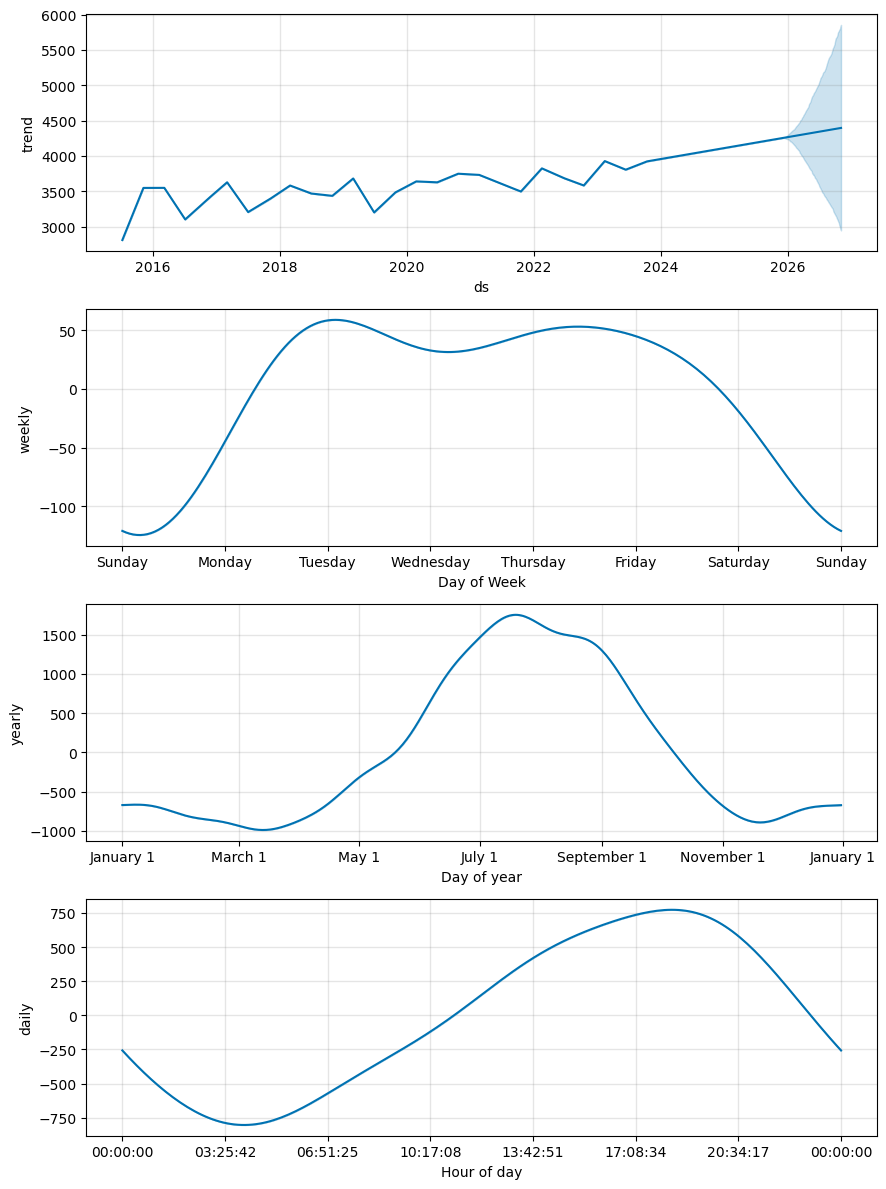

In [64]:
fig2 = m.plot_components(forecast)

In [65]:
# Commented this out because it takes a while, I instead saved the CSV and import it.
"""
df_cv = cross_validation(
    model=m,
    initial='365',   
    period='30 days',       
    horizon='90 days',
)

df_metrics.to_csv("prophet_metrics.csv")
"""



'\ndf_cv = cross_validation(\n    model=m,\n    initial=\'365\',   \n    period=\'30 days\',       \n    horizon=\'90 days\',\n)\n\ndf_metrics.to_csv("prophet_metrics.csv")\n'

In [66]:
df_cv = pd.read_csv("prophet_metrics.csv")

In [67]:
df_cv

,Unnamed: 0,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0,9 days 00:00:00,4.735560e+05,688.154047,508.385047,0.143523,0.113244,0.149014,0.710386
1,1,9 days 01:00:00,4.758501e+05,689.818919,509.215406,0.143837,0.113438,0.149403,0.709936
2,2,9 days 02:00:00,4.785917e+05,691.803253,510.197674,0.144193,0.113595,0.149844,0.709487
3,3,9 days 03:00:00,4.814740e+05,693.883241,511.195566,0.144564,0.113712,0.150292,0.708930
4,4,9 days 04:00:00,4.845055e+05,696.064292,512.184440,0.144940,0.113843,0.150733,0.708410
...,...,...,...,...,...,...,...,...,...
1940,1940,89 days 20:00:00,2.995016e+07,5472.674248,1298.695448,0.415451,0.140813,0.209195,0.645168
1941,1941,89 days 21:00:00,2.996416e+07,5473.953104,1298.876906,0.415619,0.140867,0.209246,0.645146
1942,1942,89 days 22:00:00,2.997834e+07,5475.247557,1299.153526,0.415829,0.140961,0.209321,0.644951
1943,1943,89 days 23:00:00,2.999243e+07,5476.534455,1299.511140,0.416075,0.141013,0.209423,0.644717


In [68]:
future = m.make_future_dataframe(periods=216, freq='H')
future.tail()

,ds
90618,2025-11-09 19:00:00
90619,2025-11-09 20:00:00
90620,2025-11-09 21:00:00
90621,2025-11-09 22:00:00
90622,2025-11-09 23:00:00


In [69]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-08 01:00:00,2811.334271,3265.507788,4697.787161,2811.334271,2811.334271,1170.994066,1170.994066,1170.994066,-476.184665,...,32.317819,32.317819,32.317819,1614.860913,1614.860913,1614.860913,0.0,0.0,0.0,3982.328337
1,2015-07-08 02:00:00,2811.589112,3115.249132,4488.303266,2811.589112,2811.589112,999.724354,999.724354,999.724354,-647.912519,...,31.904725,31.904725,31.904725,1615.732147,1615.732147,1615.732147,0.0,0.0,0.0,3811.313466
2,2015-07-08 03:00:00,2811.843953,2968.303311,4352.557622,2811.843953,2811.843953,887.539562,887.539562,887.539562,-760.706291,...,31.644265,31.644265,31.644265,1616.601587,1616.601587,1616.601587,0.0,0.0,0.0,3699.383515
3,2015-07-08 04:00:00,2812.098794,2985.200941,4280.185692,2812.098794,2812.098794,845.965927,845.965927,845.965927,-803.038481,...,31.535186,31.535186,31.535186,1617.469222,1617.469222,1617.469222,0.0,0.0,0.0,3658.064721
4,2015-07-08 05:00:00,2812.353635,2945.017684,4360.637900,2812.353635,2812.353635,878.496185,878.496185,878.496185,-771.413296,...,31.574442,31.574442,31.574442,1618.335039,1618.335039,1618.335039,0.0,0.0,0.0,3690.849821


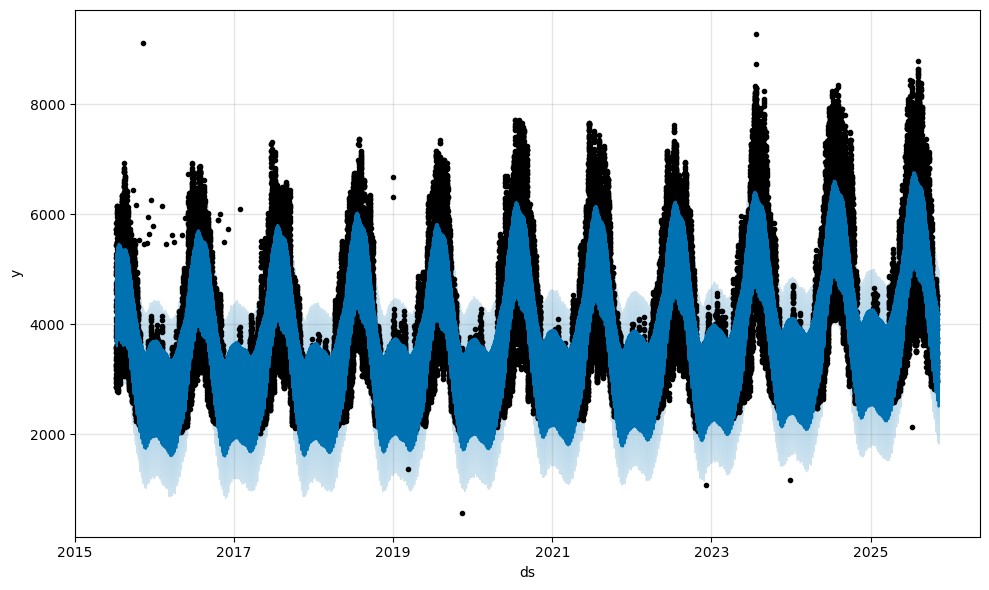

In [70]:
fig1 = m.plot(forecast)

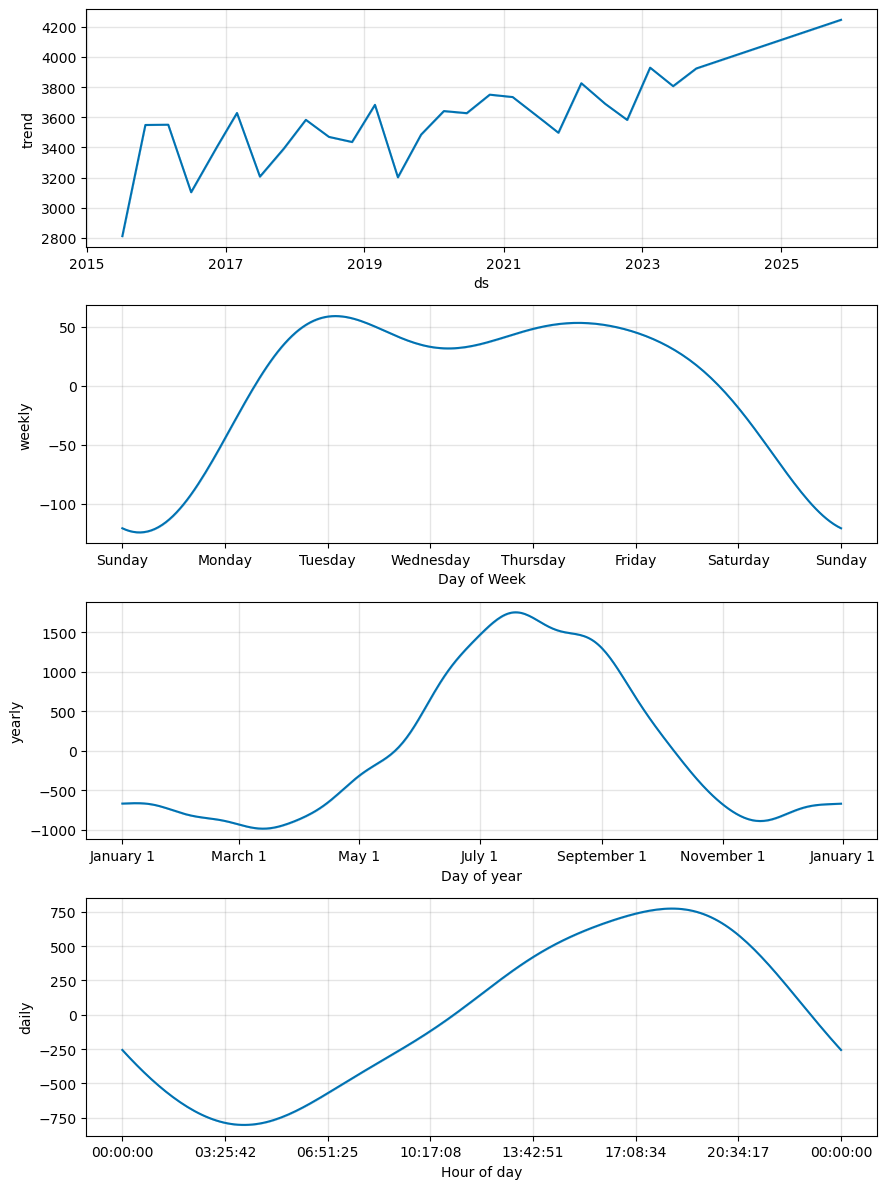

In [71]:
fig2 = m.plot_components(forecast)

In [72]:
forecast = forecast[['ds', 'yhat']]

In [73]:
forecast = forecast.rename(columns={'ds': 'Local time', 'yhat':'Predicted Demand (MWh)'})
forecast["Local time"] = pd.to_datetime(forecast['Local time'])
forecast = forecast.set_index("Local time")

In [74]:
forecast

,Predicted Demand (MWh)
Local time,
2015-07-08 01:00:00,3982.328337
2015-07-08 02:00:00,3811.313466
2015-07-08 03:00:00,3699.383515
2015-07-08 04:00:00,3658.064721
2015-07-08 05:00:00,3690.849821
...,...
2025-11-09 19:00:00,4104.368176
2025-11-09 20:00:00,4021.020129
2025-11-09 21:00:00,3853.246331


In [75]:
real_df = df.copy()
real_df = real_df[["Demand (MWh)"]]
real_df

,Demand (MWh)
Local time,
2015-07-08 01:00:00,3817.0
2015-07-08 02:00:00,3590.0
2015-07-08 03:00:00,3396.0
2015-07-08 04:00:00,3258.0
2015-07-08 05:00:00,3230.0
...,...
2025-10-31 19:00:00,4213.0
2025-10-31 20:00:00,3906.0
2025-10-31 21:00:00,3747.0


In [76]:
forecast_loc = forecast.loc[:'2025-10-31 23:00:00']
forecast_loc

,Predicted Demand (MWh)
Local time,
2015-07-08 01:00:00,3982.328337
2015-07-08 02:00:00,3811.313466
2015-07-08 03:00:00,3699.383515
2015-07-08 04:00:00,3658.064721
2015-07-08 05:00:00,3690.849821
...,...
2025-10-31 19:00:00,4327.758013
2025-10-31 20:00:00,4234.359133
2025-10-31 21:00:00,4056.181540


In [77]:
merged_df = pd.merge(real_df, forecast_loc, on='Local time')
merged_df.to_csv("prophet_real_versus_predicted.csv")

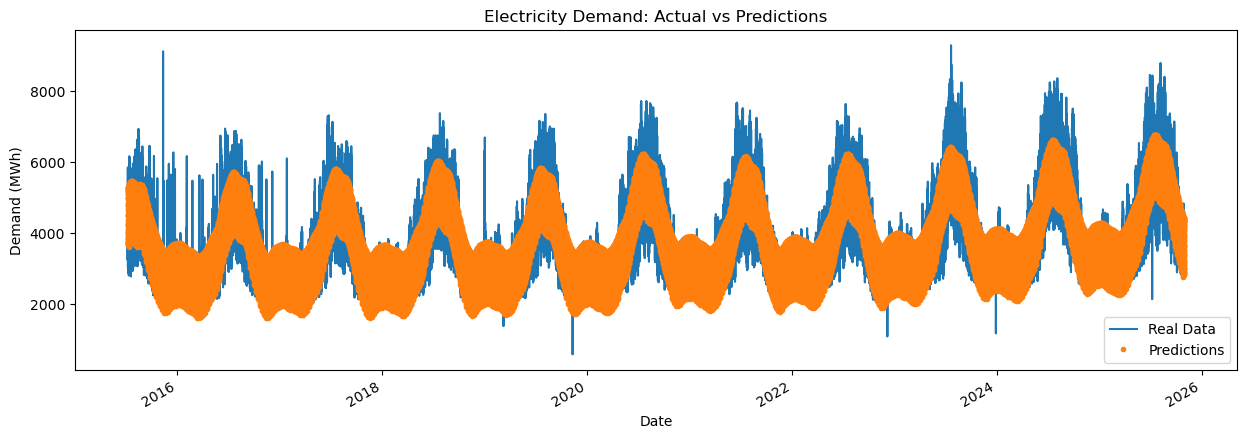

In [78]:
fig, ax = plt.subplots(figsize=(15,5))
merged_df['Demand (MWh)'].plot(ax=ax)
merged_df['Predicted Demand (MWh)'].plot(ax=ax, style='.')
plt.legend(['Real Data', 'Predictions'])
ax.set_title('Electricity Demand: Actual vs Predictions')
ax.set_ylabel('Demand (MWh)')
ax.set_xlabel('Date')
plt.show()

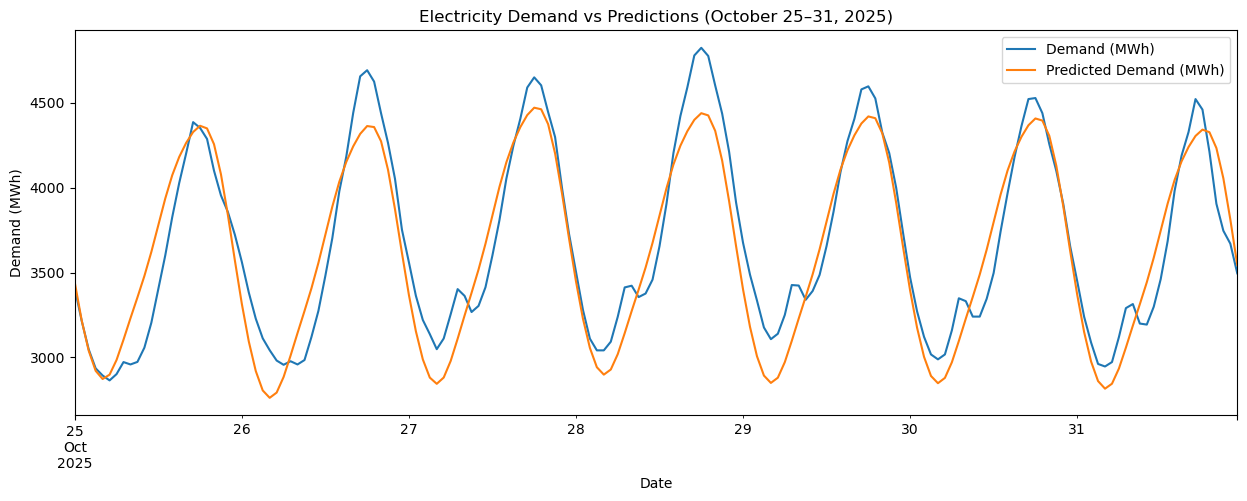

In [79]:
week_df = merged_df.loc['2025-10-25':'2025-10-31', ['Demand (MWh)', 'Predicted Demand (MWh)']]

# Plot
ax = week_df.plot(figsize=(15,5))
ax.set_title('Electricity Demand vs Predictions (October 25–31, 2025)')
ax.set_ylabel('Demand (MWh)')
ax.set_xlabel('Date')
plt.show()

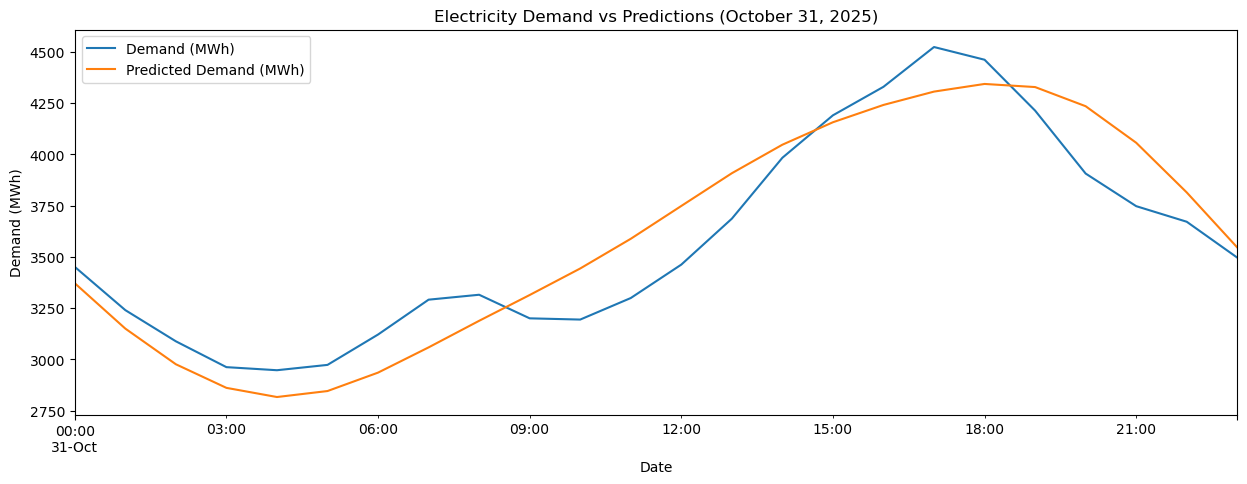

In [80]:
one_df = merged_df.loc['2025-10-31 00:00:00':'2025-10-31 23:00:00', ['Demand (MWh)', 'Predicted Demand (MWh)']]

# Plot
ax = one_df.plot(figsize=(15,5))
ax.set_title('Electricity Demand vs Predictions (October 31, 2025)')
ax.set_ylabel('Demand (MWh)')
ax.set_xlabel('Date')
plt.show()

# This is comparing only the historical data's performance, and Prophet isn't designed for that:

In [81]:
actual = merged_df['Demand (MWh)']
predicted = merged_df['Predicted Demand (MWh)']

mse_value = mean_squared_error(actual, predicted)
rmse_value = np.sqrt(mse_value)
mae = mean_absolute_error(actual, predicted)
mape = (abs(actual - predicted) / actual).mean() * 100
bias = (predicted - actual).mean()
r2 = r2_score(actual, predicted) * 100
demand_mean = actual.mean()
percentage_rmse = (rmse_value / demand_mean) * 100

print(f"MSE: {mse_value:.2f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Bias: {bias:.2f}")
print(f"Mean: {demand_mean:.2f}")
print(f"RMSE % of Mean: {percentage_rmse:.2f}%")
print(f"R2 Score: {r2:.2f}%")

MSE: 302656.82
RMSE: 550.14
MAE: 432.90
MAPE: 12.08%
Bias: -0.00
Mean: 3681.50
RMSE % of Mean: 14.94%
R2 Score: 79.70%


# I will show the metrics for the prediction of 7 days into the future, compared to the real data

In [82]:
forecast = forecast.loc['2025-11-01 00:00:00':]

# 1-day (24 hours)
forecast_1d = forecast.head(24)

# 7-day (168 hours)
forecast_7d = forecast.head(168)

# 9-day (216 hours)
forecast_9d = forecast.head(216)

In [83]:
forecast_1d.head(5)

,Predicted Demand (MWh)
Local time,
2025-11-01 00:00:00,3287.191874
2025-11-01 01:00:00,3062.736660
2025-11-01 02:00:00,2885.557483
2025-11-01 03:00:00,2767.201336
2025-11-01 04:00:00,2719.210003


In [84]:
future_demand_real = pd.read_excel("srp_demand_october_november.xlsx")

In [85]:
future_demand_real = future_demand_real.set_index('Local time')

In [86]:
future_demand_real = future_demand_real.rename(columns={'Adjusted D':'Demand (MWh)'})
future_demand_real = future_demand_real[['Demand (MWh)']]

In [87]:
future_demand_real.loc['2025-11-01 00:00:00':'2025-11-09 23:00:00']

,Demand (MWh)
Local time,
2025-11-01 00:00:00,3280.0
2025-11-01 01:00:00,3140.0
2025-11-01 02:00:00,3006.0
2025-11-01 03:00:00,2934.0
2025-11-01 04:00:00,2865.0
...,...
2025-11-09 19:00:00,4325.0
2025-11-09 20:00:00,4164.0
2025-11-09 21:00:00,4011.0


In [88]:
future_demand_compared = pd.merge(future_demand_real, forecast_9d, on='Local time')

In [89]:
future_demand_compared

,Demand (MWh),Predicted Demand (MWh)
Local time,,
2025-11-01 00:00:00,3280.0,3287.191874
2025-11-01 01:00:00,3140.0,3062.736660
2025-11-01 02:00:00,3006.0,2885.557483
2025-11-01 03:00:00,2934.0,2767.201336
2025-11-01 04:00:00,2865.0,2719.210003
...,...,...
2025-11-09 19:00:00,4325.0,4104.368176
2025-11-09 20:00:00,4164.0,4021.020129
2025-11-09 21:00:00,4011.0,3853.246331


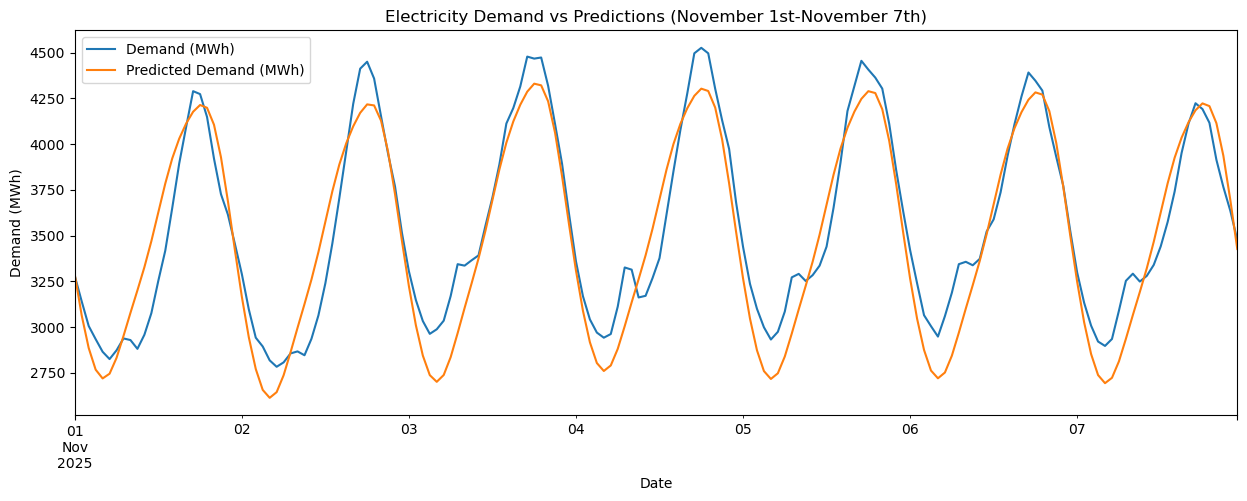

MSE: 32690.38
RMSE: 180.80
MAE: 151.65
MAPE: 4.50%
Bias: -47.76
Mean: 3548.74
RMSE % of Mean: 5.09%
R2 Score: 87.44%


In [90]:
one_week = future_demand_compared.loc['2025-11-01 00:00:00':'2025-11-07 23:00:00', ['Demand (MWh)', 'Predicted Demand (MWh)']]

# Plot
ax = one_week.plot(figsize=(15,5))
ax.set_title('Electricity Demand vs Predictions (November 1st-November 7th)')
ax.set_ylabel('Demand (MWh)')
ax.set_xlabel('Date')
plt.show()

actual = one_week['Demand (MWh)']
predicted = one_week['Predicted Demand (MWh)']

mse_value = mean_squared_error(actual, predicted)
rmse_value = np.sqrt(mse_value)
mae = mean_absolute_error(actual, predicted)
mape = (abs(actual - predicted) / actual).mean() * 100
bias = (predicted - actual).mean()
r2 = r2_score(actual, predicted) * 100
demand_mean = actual.mean()
percentage_rmse = (rmse_value / demand_mean) * 100

print(f"MSE: {mse_value:.2f}")
print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Bias: {bias:.2f}")
print(f"Mean: {demand_mean:.2f}")
print(f"RMSE % of Mean: {percentage_rmse:.2f}%")
print(f"R2 Score: {r2:.2f}%")

In [91]:
# Function to compute metrics
def compute_metrics(actual, predicted, model_name):
    mse_value = mean_squared_error(actual, predicted)
    rmse_value = np.sqrt(mse_value)
    mae = mean_absolute_error(actual, predicted)
    mape = (abs(actual - predicted) / actual).mean() * 100
    bias = (predicted - actual).mean()
    demand_mean = actual.mean()
    percentage_rmse = (rmse_value / demand_mean) * 100
    r2 = r2_score(actual, predicted) * 100
    
    return {
        "Model": model_name,
        "MSE": mse_value,
        "RMSE": rmse_value,
        "MAE": mae,
        "MAPE (%)": mape,
        "Bias": bias,
        "Mean": demand_mean,
        "RMSE % of Mean": percentage_rmse,
        "R2 (%)": r2
    }

# --- Define the period for evaluation ---
start_date = '2025-10-25 00:00:00'
end_date   = '2025-10-31 23:00:00'

# --- Baseline ---
baseline_df = df.loc[start_date:end_date, ['Demand (MWh)', 'Demand Forecast (MWh)']]
baseline_metrics = compute_metrics(
    baseline_df['Demand (MWh)'], 
    baseline_df['Demand Forecast (MWh)'], 
    "Baseline (7-day forecast)"
)

# --- XGBoost ---
xgb_df = test.loc[start_date:end_date, ['Demand (MWh)', 'ml_prediction']]
xgb_metrics = compute_metrics(
    xgb_df['Demand (MWh)'], 
    xgb_df['ml_prediction'], 
    "XGBoost (7-day forecast)"
)

# --- Prophet ---
prophet_df = merged_df.loc[start_date:end_date, ['Demand (MWh)', 'Predicted Demand (MWh)']]
prophet_metrics = compute_metrics(
    prophet_df['Demand (MWh)'], 
    prophet_df['Predicted Demand (MWh)'], 
    "Prophet (7-day forecast)"
)

# --- Combine all metrics into a DataFrame ---
df_metrics = pd.DataFrame([baseline_metrics, xgb_metrics, prophet_metrics])

# Display with 2 decimal places and sort by RMSE
pd.set_option("display.float_format", "{:.2f}".format)
df_metrics_sorted = df_metrics.sort_values(by="RMSE", ascending=True)
df_metrics_sorted

,Model,MSE,RMSE,MAE,MAPE (%),Bias,Mean,RMSE % of Mean,R2 (%)
0,Baseline (7-day forecast),30239.32,173.89,139.57,3.85,-95.28,3675.92,4.73,89.94
2,Prophet (7-day forecast),38371.41,195.89,166.38,4.66,-37.74,3675.92,5.33,87.24
1,XGBoost (7-day forecast),40883.55,202.20,152.43,3.94,-115.48,3675.92,5.50,86.40


In [92]:
# df_metrics_sorted.to_csv("model_metric_comparison.csv")

In [93]:
df

,Temperature (F),Demand (MWh),Net Generation (MWh),Demand Forecast (MWh),Total Interchange (MWh),hour,dayofweek,quarter,month,year,...,is_holiday,is_weekend,is_day,Demand (MWh)_lag_1,Demand (MWh)_lag_2,Demand (MWh)_lag_3,Demand (MWh)_lag_6,Demand (MWh)_lag_24,Demand (MWh)_lag_48,Demand (MWh)_lag_168
Local time,,,,,,,,,,,,,,,,,,,,,
2015-07-08 01:00:00,85,3817.00,4121.00,3329.00,304.00,1,2,3,7,2015,...,0,0,0,4144.00,4580.00,5039.00,5882.00,3808.00,3358.00,4103.00
2015-07-08 02:00:00,82,3590.00,3750.00,3154.00,160.00,2,2,3,7,2015,...,0,0,0,3817.00,4144.00,4580.00,5623.00,3596.00,3196.00,3897.00
2015-07-08 03:00:00,85,3396.00,3391.00,3455.00,-5.00,3,2,3,7,2015,...,0,0,0,3590.00,3817.00,4144.00,5399.00,3473.00,3174.00,3694.00
2015-07-08 04:00:00,84,3258.00,3127.00,3347.00,-131.00,4,2,3,7,2015,...,0,0,0,3396.00,3590.00,3817.00,5039.00,3377.00,3124.00,3590.00
2015-07-08 05:00:00,81,3230.00,3135.00,3335.00,-95.00,5,2,3,7,2015,...,0,0,0,3258.00,3396.00,3590.00,4580.00,3348.00,3173.00,3546.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,68,4213.00,5934.00,4239.00,1720.00,19,4,4,10,2025,...,0,0,1,4461.00,4523.00,4329.00,3686.00,4440.00,4527.00,4231.00
2025-10-31 20:00:00,64,3906.00,5694.00,4054.00,1788.00,20,4,4,10,2025,...,0,0,0,4213.00,4461.00,4523.00,3983.00,4257.00,4326.00,4050.00
2025-10-31 21:00:00,64,3747.00,5503.00,3945.00,1755.00,21,4,4,10,2025,...,0,0,0,3906.00,4213.00,4461.00,4190.00,4100.00,4205.00,3920.00


# Correlation testing

In [116]:
from scipy.stats import pearsonr

r, p = pearsonr(df["Temperature (F)"], df["Demand (MWh)"])
print("Pearson r:", r)
print("p-value:", p)


Pearson r: 0.7693924424882356
p-value: 0.0


In [97]:
population_and_demand = pd.DataFrame({
    "Year": [2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016],
    "Population": [7583692.40, 7475644.80, 7367597.20, 7259549.60, 7151502.00, 7268175.00, 7164230.00, 7109843.75, 7055457.50],
    "Demand_MWh": [35683775.0, 33912809.0, 32464874.0, 31793878.0, 32208503.0, 30291298.0, 30381482.0, 29804595.0, 29470736.0]
})

r, p = pearsonr(population_and_demand["Population"], population_and_demand["Demand_MWh"])
print("Pearson r:", r)
print("p-value:", p)


Pearson r: 0.913140966718925
p-value: 0.0005836238163712237


In [108]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df["Demand (MWh)"],
                          groups=df["Season"],
                          alpha=0.05)
print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj   lower      upper    reject
-----------------------------------------------------------
  Fall Spring  -369.9343   0.0  -392.2844  -347.5842   True
  Fall Summer  1449.4142   0.0  1427.3786  1471.4498   True
  Fall Winter  -571.9387   0.0  -594.3966  -549.4808   True
Spring Summer  1819.3485   0.0  1797.0093  1841.6877   True
Spring Winter  -202.0044   0.0  -224.7602  -179.2485   True
Summer Winter -2021.3529   0.0 -2043.7999 -1998.9059   True
-----------------------------------------------------------
